In [1]:
import pandas_profiling as pp
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def CalcOutliers(df_num): 
    '''
    
    Leonardo Ferreira 20/10/2018
    Set a numerical value and it will calculate the upper, lower and total number of outliers
    It will print a lot of statistics of the numerical feature that you set on input
    
    '''
    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Identified outliers: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [3]:
def dist(df, col, title, x, y):

    # define the size of figures that I will build
    plt.figure(figsize=(16,5))

    g = sns.countplot(x=col, data=df, color='forestgreen') # seting the seaborn countplot to known the points distribuition
    g.set_title(title, fontsize=20) # seting title and size of font
    g.set_xlabel(x, fontsize=15) # seting xlabel and size of font
    g.set_ylabel(y, fontsize=15) # seting ylabel and size of font
    plt.show() #rendering the graphs

In [4]:
def analise_cat_1(df,var,label = '',fl_ordena=0, num = False, q = 0, q2 = 0, y = 'ratingValue_flag'):
    if label == '':
        label = var
    df_ = df.copy()
    if num:
        if q == 0:
            if q2 == 0:
                df_[var+'_cat'] = pd.qcut(df_[var],q= [0.0,0.2,0.5,0.8,1.0],retbins=True,duplicates='drop')[0].cat.add_categories('missing')
                var= var+'_cat'
            else:
                df_[var+'_cat'] = pd.qcut(df_[var],q= q2,retbins=True,duplicates='drop')[0].cat.add_categories('missing')
                var= var+'_cat'
        else :
            df_[var+'_cat'] = pd.cut(df_[var],bins=q).cat.add_categories('missing')
            var= var+'_cat'
    print('\n')
    print('Análise da variável {}'.format(var))
    print('# valores distintos {}'.format(df_[var].nunique()))
    try:
        df_[var] = df_[var].fillna('missing')
    except :
        df_[var] = df_[var].cat.add_categories('missing').fillna('missing')
    total_maus = df_[y].sum()
    total_bons = df_.shape[0] - df_[y].sum()
    def tx(x):
        return sum(x)*100/sum(1 -x +x)
    def pct(x):
        return sum(1-x+x)*1.0/ (df_.shape[0])
    def pct_maus(x):
        return (sum(x)/total_maus )
    def rr(x):
        return (sum(x)/total_maus )/(sum(1-x)/total_bons)
    def WoE(x):
        return np.log(rr(x))
    def IV(x):
        return -(sum(1-x)/total_bons - sum(x)/total_maus)*WoE(x)
    s = df_.groupby(var).agg({y: [np.size,pct,pct_maus, tx,rr,WoE,IV]})[y]
    def color_negative_green(val):
        color = 'red' if val < 0 else 'black'
        return 'color: %s' % color
    print('IV : {:.3f}'.format(s.IV.sum()))
    #print('Beta : {:.3f}'.format(dic_beta[var]))
    t = s.style.applymap(color_negative_green)
    display(pd.DataFrame(df_[var].value_counts()).join(pd.DataFrame(df_[var].value_counts(normalize= True)*100), lsuffix = 'k').rename(columns = {var+'k': '#', var: '%'}))
    display(t)
    by_var = df_.groupby(var).agg({y:[np.size, np.mean]})[y]
    if fl_ordena ==1 :
        by_var =  by_var.sort_values(by = 'mean')
    Y1 = by_var['size']
    Y2 = by_var['mean']
    Y_mean = np.ones(shape=(len(Y1.index)))* df_[y].mean()
    index =  np.arange(len(Y1.index))
    #with plt.style.context('my_custom_style'):
    if True:
        plt.bar(index,Y1,alpha = 0.3, color= 'gray')
        plt.grid(False)
        plt.xticks(rotation = 20         if var[:2] not in ( 'fl', 'cd')  else 0)
        plt.ylabel('# registros')
        plt.twinx()
        plt.gca().set_xticks(index)
        plt.gca().set_xticklabels([Y1.index[i] for i in index], rotation = 40)
        plt.plot(index,Y_mean,label=  'tx. média evento')
        plt.plot(index,Y2,marker = 'o',label=  'tx. evento')
        plt.gca().set_yticklabels([ ' {:.2f}%'.format( i*100) for i in plt.gca().get_yticks()])
        plt.grid(False)
        plt.title('Bivariada  {}'.format(label))
        plt.ylabel('tx. evento')
        plt.xlabel(label)
        if var[:2] in ( 'fl', 'cd'):
            plt.legend(loc= 9,bbox_to_anchor=(0.5, -0.1))
        else:
            plt.legend(loc= 9,bbox_to_anchor=(0.5, -0.35))
        plt.show()
        print('\n')
    return label,np.round(s.IV.sum(),3), np.round(s.rr.mean(),3)

In [5]:
df = pd.read_csv('all_wines.csv')

In [6]:
df.columns

Index(['link', 'Nome', 'País', 'Preço_Sócio', 'Preço_Normal', 'Pontuação',
       'Avaliações', 'somelier', 'Decantação', 'Origem', 'Olfativo',
       'Amadurecimento', 'Uvas', 'Gustativo', 'Visual', 'Harmonização',
       'Temperatura de serviço', 'Safra', 'Classificação', 'Teor Alcoólico',
       'Vinícola', 'Tipo', 'Potencial de guarda'],
      dtype='object')

In [7]:
df.head()

,link,Nome,País,Preço_Sócio,Preço_Normal,Pontuação,Avaliações,somelier,Decantação,Origem,...,Gustativo,Visual,Harmonização,Temperatura de serviço,Safra,Classificação,Teor Alcoólico,Vinícola,Tipo,Potencial de guarda
0,https://wine.com.br/vinhos/maison-le-star-rose...,Maison Le Star Rosé On Ice,NaN,NaN,NaN,3.5,26.0,"Rosé francês frutado, leve, fresco e com doçur...",NaN,NaN,...,"Leve, acidez agradável, frutado, doçura média",Rosa claro,"Salada de frutos do mar, bruschettas e tapas, ...",8 °C,NaN,Meio Seco/Demi-Sec,11.50% ABV,Maison Le Star,Rosé,3 anos
1,https://wine.com.br/vinhos/ropiteau-freres-les...,Ropiteau Frères Les Plants Nobles Pinot Noir 2017,NaN,NaN,NaN,4.5,44.0,"Com aroma de frutas vermelhas, sobre notas de ...",NaN,França-Languedoc-Roussillon,...,"Corpo de leve para médio, fresco, taninos deli...",Rubi,"Ratatouille, iscas de filé mignon acebolado, n...",15 °C,2017.0,Seco,12.50% ABV,Ropiteau Frères,Tinto,4 anos
2,https://wine.com.br/vinhos/punta-paramo-malbec...,Punta Paramo Malbec 2018,NaN,NaN,NaN,3.5,8.0,"Estilo de Malbec fácil de beber e macio, ideal...",NaN,Argentina-Mendoza,...,"Corpo de leve para médio, taninos macios, acid...",Rubi com reflexos violáceos,"Fraldinha ao forno, pizza de calabresa, quiche...",15 °C,2018.0,Seco,13.80% ABV,Bodega Don Cristóbal 1492,Tinto,7 anos
3,https://wine.com.br/vinhos/gerard-bertrand-gra...,Gérard Bertrand Grand Terroir A.O.P. Les Aspre...,NaN,NaN,NaN,1.0,2.0,Nasce de videiras cultivada em Les Aspres (ári...,30 minutos,França-Les Aspres,...,"Médio corpo, taninos sedosos, acidez agradável...",Rubi,"Pernil de cordeiro assado, paleta de javali co...",16 °C,2015.0,Seco,14.00% ABV,Gérard Bertrand,Tinto,7 anos
4,https://wine.com.br/vinhos/marques-de-somera-g...,Marqués de Somera Garnacha 2018,NaN,NaN,NaN,4.0,17.0,Esse exemplar é elaborado na região espanhola ...,NaN,Espanha-Cariñena,...,"Médio corpo, frutado, fresco, taninos macios,",Rubi,"Nhoque à bolonhesa, filé à parmigiana, arroz c...",15 °C,2018.0,Seco,13.00% ABV,Covinca,Tinto,4 anos


In [8]:
df.columns = ['Link', 'Nome', 'País', 'Preço_Sócio', 'Preço_Normal', 'Pontuação',
       'Avaliações', 'Somelier', 'Decantação', 'Origem', 'Olfativo',
       'Amadurecimento', 'Uvas', 'Gustativo', 'Visual', 'Harmonização',
       'Temperatura', 'Safra', 'Classificação', 'Teor_Alcoólico',
       'Vinícola', 'Tipo', 'Potencial_Guarda']

Remover kits de vinhos, estes não representam amostras de interesse. 

In [9]:
kit = ((df.Nome.str.contains('Kit')) | (df.Nome.str.contains("KIT")) | (df.Nome.str.contains('WineBox')))

In [10]:
df[kit].shape

(121, 23)

In [11]:
df = df[~kit]

In [12]:
df[df.Nome.str.contains('Experiencias')].shape

(3, 23)

In [13]:
df = df[~df.Nome.str.contains('Experiencias')]

In [14]:
df = df[~df.Nome.str.contains("Vinho Misterioso")]

Transformar Strings em Dados Numéricos

In [15]:
df.Temperatura.unique()

array(['8 °C', '15 °C', '16 °C', '9 °C', '7 °C', '10 °C', nan, '18 °C',
       '14 °C', '5 °C', '6 °C', '17 °C', '11 °C', '12 °C', '13 °C',
       '4 °C'], dtype=object)

In [16]:
df['Temperatura'] = df.Temperatura.str.replace(" °C", '').astype(float)

In [17]:
df.Temperatura.unique()

array([ 8., 15., 16.,  9.,  7., 10., nan, 18., 14.,  5.,  6., 17., 11.,
       12., 13.,  4.])

In [18]:
df.Teor_Alcoólico.unique()

array(['11.50% ABV', '12.50% ABV', '13.80% ABV', '14.00% ABV',
       '13.00% ABV', '12.00% ABV', '7.50% ABV', '14.50% ABV',
       '13.50% ABV', nan, '10.00% ABV', '15.50% ABV', '11.00% ABV',
       '9.50% ABV', '12.80% ABV', '14.26% ABV', '15.00% ABV',
       '14.30% ABV', '10.50% ABV', '14.10% ABV', '13.40% ABV',
       '14.20% ABV', '15.10% ABV', '11.70% ABV', '11.80% ABV',
       '16.00% ABV', '13.70% ABV', '8.00% ABV', '12.40% ABV',
       '12.70% ABV', '13.90% ABV', '9.00% ABV', '15.40% ABV', '5.50% ABV',
       '17.00% ABV', '14.40% ABV', '13.20% ABV', '13.10% ABV',
       '11.60% ABV', '15.20% ABV', '15.30% ABV', '14.70% ABV',
       '14.60% ABV', '20.00% ABV', '12.20% ABV', '17.50% ABV',
       '14.90% ABV', '13.30% ABV', '15.60% ABV', '11.90% ABV',
       '14.09% ABV', '13.95% ABV', '12.30% ABV', '13.60% ABV',
       '14.80% ABV', '19.50% ABV', '6.50% ABV', '7.00% ABV', '19.00% ABV',
       '20.40% ABV', '18.00% ABV', '7.80% ABV', '0.50% ABV', '14.68% ABV',
       '12.90% AB

In [19]:
df['Teor_Alcoólico'] = df.Teor_Alcoólico.str.replace("% ABV", '').astype(float)

In [20]:
df.Teor_Alcoólico.unique()

array([11.5 , 12.5 , 13.8 , 14.  , 13.  , 12.  ,  7.5 , 14.5 , 13.5 ,
         nan, 10.  , 15.5 , 11.  ,  9.5 , 12.8 , 14.26, 15.  , 14.3 ,
       10.5 , 14.1 , 13.4 , 14.2 , 15.1 , 11.7 , 11.8 , 16.  , 13.7 ,
        8.  , 12.4 , 12.7 , 13.9 ,  9.  , 15.4 ,  5.5 , 17.  , 14.4 ,
       13.2 , 13.1 , 11.6 , 15.2 , 15.3 , 14.7 , 14.6 , 20.  , 12.2 ,
       17.5 , 14.9 , 13.3 , 15.6 , 11.9 , 14.09, 13.95, 12.3 , 13.6 ,
       14.8 , 19.5 ,  6.5 ,  7.  , 19.  , 20.4 , 18.  ,  7.8 ,  0.5 ,
       14.68, 12.9 , 12.28])

In [21]:
df.Potencial_Guarda.unique()

array(['3 anos', '4 anos', '7 anos', '2 anos', '6 anos', '5 anos', nan,
       '20 anos', '10 anos', '8 anos', '9 anos', '13 anos', '15 anos',
       '12 anos', '11 anos', '14 anos', '30 anos', '25 anos', '35 anos',
       '40 anos', '23 anos', '50 anos', '18 anos', '17 anos', '16 anos',
       '22 anos', '19 anos', '44 anos', '1 ano'], dtype=object)

In [22]:
df['Potencial_Guarda'] = df.Potencial_Guarda.str.replace(" anos", '')
df['Potencial_Guarda'] = df.Potencial_Guarda.str.replace(" ano", '').astype(float)

In [23]:
df.head()

,Link,Nome,País,Preço_Sócio,Preço_Normal,Pontuação,Avaliações,Somelier,Decantação,Origem,...,Gustativo,Visual,Harmonização,Temperatura,Safra,Classificação,Teor_Alcoólico,Vinícola,Tipo,Potencial_Guarda
0,https://wine.com.br/vinhos/maison-le-star-rose...,Maison Le Star Rosé On Ice,NaN,NaN,NaN,3.5,26.0,"Rosé francês frutado, leve, fresco e com doçur...",NaN,NaN,...,"Leve, acidez agradável, frutado, doçura média",Rosa claro,"Salada de frutos do mar, bruschettas e tapas, ...",8.0,NaN,Meio Seco/Demi-Sec,11.5,Maison Le Star,Rosé,3.0
1,https://wine.com.br/vinhos/ropiteau-freres-les...,Ropiteau Frères Les Plants Nobles Pinot Noir 2017,NaN,NaN,NaN,4.5,44.0,"Com aroma de frutas vermelhas, sobre notas de ...",NaN,França-Languedoc-Roussillon,...,"Corpo de leve para médio, fresco, taninos deli...",Rubi,"Ratatouille, iscas de filé mignon acebolado, n...",15.0,2017.0,Seco,12.5,Ropiteau Frères,Tinto,4.0
2,https://wine.com.br/vinhos/punta-paramo-malbec...,Punta Paramo Malbec 2018,NaN,NaN,NaN,3.5,8.0,"Estilo de Malbec fácil de beber e macio, ideal...",NaN,Argentina-Mendoza,...,"Corpo de leve para médio, taninos macios, acid...",Rubi com reflexos violáceos,"Fraldinha ao forno, pizza de calabresa, quiche...",15.0,2018.0,Seco,13.8,Bodega Don Cristóbal 1492,Tinto,7.0
3,https://wine.com.br/vinhos/gerard-bertrand-gra...,Gérard Bertrand Grand Terroir A.O.P. Les Aspre...,NaN,NaN,NaN,1.0,2.0,Nasce de videiras cultivada em Les Aspres (ári...,30 minutos,França-Les Aspres,...,"Médio corpo, taninos sedosos, acidez agradável...",Rubi,"Pernil de cordeiro assado, paleta de javali co...",16.0,2015.0,Seco,14.0,Gérard Bertrand,Tinto,7.0
4,https://wine.com.br/vinhos/marques-de-somera-g...,Marqués de Somera Garnacha 2018,NaN,NaN,NaN,4.0,17.0,Esse exemplar é elaborado na região espanhola ...,NaN,Espanha-Cariñena,...,"Médio corpo, frutado, fresco, taninos macios,",Rubi,"Nhoque à bolonhesa, filé à parmigiana, arroz c...",15.0,2018.0,Seco,13.0,Covinca,Tinto,4.0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3780 entries, 0 to 3905
Data columns (total 23 columns):
Link                3780 non-null object
Nome                3780 non-null object
País                0 non-null float64
Preço_Sócio         765 non-null float64
Preço_Normal        765 non-null float64
Pontuação           2623 non-null float64
Avaliações          2631 non-null float64
Somelier            3750 non-null object
Decantação          901 non-null object
Origem              3014 non-null object
Olfativo            3757 non-null object
Amadurecimento      3400 non-null object
Uvas                3753 non-null object
Gustativo           3758 non-null object
Visual              3756 non-null object
Harmonização        3756 non-null object
Temperatura         3737 non-null float64
Safra               3401 non-null float64
Classificação       3566 non-null object
Teor_Alcoólico      3747 non-null float64
Vinícola            3778 non-null object
Tipo                3753 non-n

In [25]:
df['País'] = df.Origem.apply(lambda x : str(x).split('-')[0])

In [26]:
df['Região'] = df.Origem.fillna('-').apply(lambda x : str(x).split('-')[1])

In [27]:
df.loc[df.País == 'nan', 'País'] = None

In [28]:
df.loc[df.Região == '', 'Região'] = None

In [29]:
df = df.drop('Origem', axis=1)

In [30]:
df.set_index('Nome', inplace=True)

In [31]:
import re
def match(x):
    match = re.match('\d+', str(x))
    if match:
        return match.group()
    return None

In [32]:
df['Decantação'] = df.Decantação.apply(match)

In [33]:
df['Decantação'] = df.Decantação.astype(float)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3780 entries, Maison Le Star Rosé On Ice to Canepa Reserva Famiglia Carménère 2017
Data columns (total 22 columns):
Link                3780 non-null object
País                3014 non-null object
Preço_Sócio         765 non-null float64
Preço_Normal        765 non-null float64
Pontuação           2623 non-null float64
Avaliações          2631 non-null float64
Somelier            3750 non-null object
Decantação          890 non-null float64
Olfativo            3757 non-null object
Amadurecimento      3400 non-null object
Uvas                3753 non-null object
Gustativo           3758 non-null object
Visual              3756 non-null object
Harmonização        3756 non-null object
Temperatura         3737 non-null float64
Safra               3401 non-null float64
Classificação       3566 non-null object
Teor_Alcoólico      3747 non-null float64
Vinícola            3778 non-null object
Tipo                3753 non-null object
Potencial_Guar

In [35]:
NUM = ['Preço_Sócio', 'Preço_Normal', 'Pontuação', 'Avaliações', 'Decantação', 'Temperatura', 'Safra', 'Teor_Alcoólico', 'Potencial_Guarda']

## Preços
A distribuição de preços possui alta amplitude, porém dispersão muito menor (IQR), como é de se esperar para vinhos. Um intervalo de preços de aproximadamente ~ `R$ 12.100` e uma amplitude interquartil de `R$ 119,43`

 * Vinho mais barato: R$ 22,24

 * Vinho mais caro: R$ 12.121,06

Claro que a maioria do catálogo tem um preço mais modesto, nesse caso a mediana e não a média é muito mais robusta a outliers.

 * Media: R$ 329,95

 * Mediana; R$ 75,18

In [36]:
CalcOutliers(df['Preço_Normal'])

Identified lowest outliers: 0
Identified upper outliers: 15
Identified outliers: 15
Non-outlier observations: 750
Total percentual of Outliers:  2.0


In [37]:
preços = df.Preço_Normal.notna()

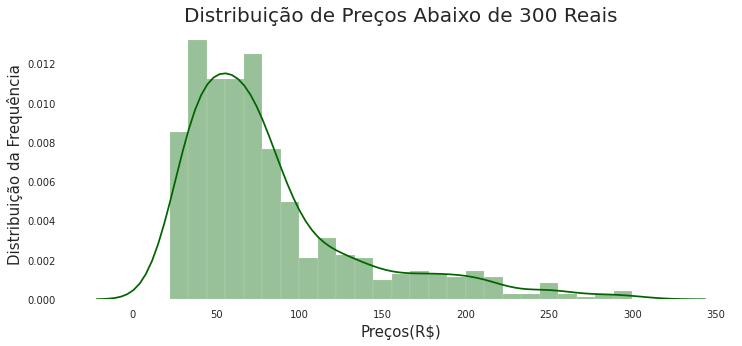

In [38]:
plt.figure(figsize=(12,5))

g = sns.distplot(df[df.Preço_Normal < 300].Preço_Normal, color='darkgreen')
g.set_title("Distribuição de Preços Abaixo de 300 Reais", fontsize=20)
g.set_xlabel("Preços(R$)", fontsize=15)
g.set_ylabel("Distribuição da Frequência", fontsize=15)


plt.show()

In [39]:
pd.qcut(df[preços].Preço_Normal, 3, retbins=True)

(Nome
 Champagne Montaudon Brut                                                      (113.213, 12121.06]
 Dark Horse The Original California Rosé 2018                                     (59.88, 113.213]
 Ropiteau Pinot Noir 2017                                                      (113.213, 12121.06]
 Latitud 33° Malbec 2018                                                          (59.88, 113.213]
 Sovento Sauvignon Blanc 2018                                          (22.238999999999997, 59.88]
                                                                                  ...             
 Fantinel Tenuta SantHelena Pinot Grigio 2016                                     (59.88, 113.213]
 Canepa Reserva Famiglia Syrah 2016                                               (59.88, 113.213]
 Viña Cosos D.O. Campo de Borja Garnacha Syrah 2018                    (22.238999999999997, 59.88]
 Baron Philippe de Rothschild La Bélière A.O.C. Bordeaux Blanc 2017    (22.238999999999997, 59.88]
 Car

In [40]:
df.loc[preços, 'Preços_Cat'] = pd.qcut(df[preços].Preço_Normal, 3, labels=[1, 2, 3])

In [41]:
df['Preços_Cat']

Nome
Maison Le Star Rosé On Ice                                            NaN
Ropiteau Frères Les Plants Nobles Pinot Noir 2017                     NaN
Punta Paramo Malbec 2018                                              NaN
Gérard Bertrand Grand Terroir A.O.P. Les Aspres 2015                  NaN
Marqués de Somera Garnacha 2018                                       NaN
                                                                     ... 
Viña Cosos D.O. Campo de Borja Garnacha Syrah 2018                      1
Baron Philippe de Rothschild La Bélière A.O.C. Bordeaux Blanc 2017      1
Carpineto Dogajolo I.G.T. Toscano Bianco 2017                           1
Nederburg 56 Hundred Pinot Noir 2017                                  NaN
Canepa Reserva Famiglia Carménère 2017                                NaN
Name: Preços_Cat, Length: 3780, dtype: object

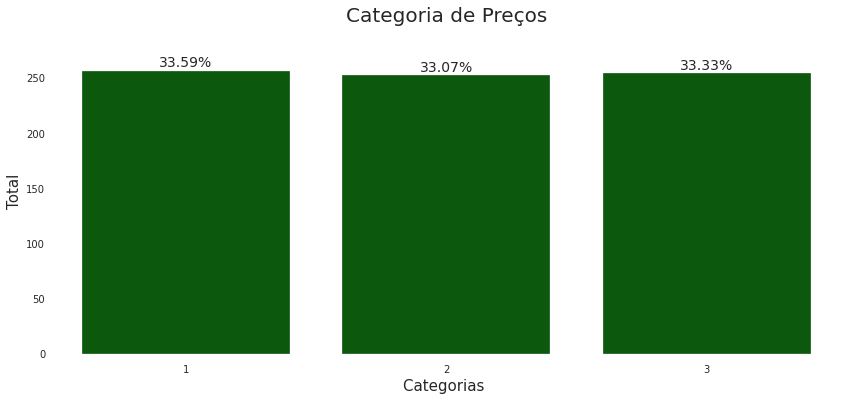

In [42]:
total = len(df[preços])
plt.figure(figsize=(14,6))

g = sns.countplot(x='Preços_Cat', color='darkgreen',
                  data=df[preços])
g.set_title("Categoria de Preços", fontsize=20)
g.set_xlabel("Categorias ", fontsize=15)
g.set_ylabel("Total", fontsize=15)

sizes=[]

for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format((height/total)*100),
            ha="center", fontsize=14) 
    
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

Como é de se esperar, os outliers existentes são superiores, i.e. Vinhos raros e/ou altamente premiados.

In [43]:
#profile = pp.ProfileReport(df[NUM])

In [44]:
#profile

## Pontuação

Os vinhos no geral são bem pontuados:
 * Média: 3.88
 * Mediana: 4.0

Adaptado de https://www.kaggle.com/kabure/wine-review-s-eda-recommend-systems

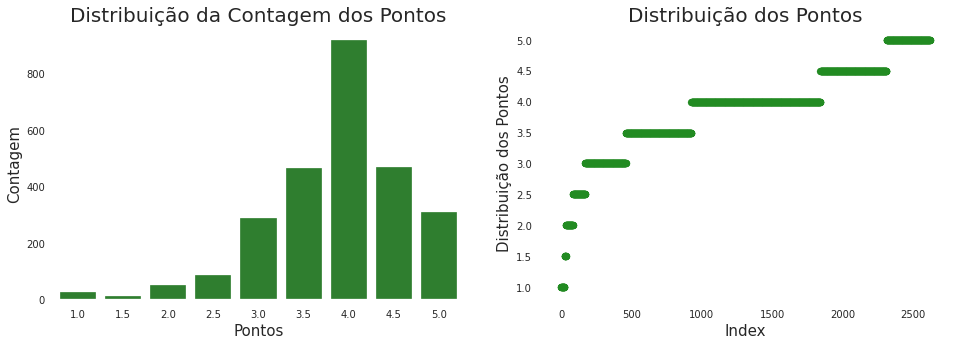

In [45]:
# define the size of figures that I will build
plt.figure(figsize=(16,5))

plt.subplot(1,2,1) # this will create a grid of 1 row and 2 columns; this is the first graphic
g = sns.countplot(x='Pontuação', data=df, color='forestgreen') # seting the seaborn countplot to known the points distribuition
g.set_title("Distribuição da Contagem dos Pontos", fontsize=20) # seting title and size of font
g.set_xlabel("Pontos", fontsize=15) # seting xlabel and size of font
g.set_ylabel("Contagem", fontsize=15) # seting ylabel and size of font

plt.subplot(1,2,2)  # this will set the second graphic of our grid
plt.scatter(range(df.shape[0]), np.sort(df.Pontuação.values), color='forestgreen') # creating a cumulative distribution
plt.xlabel('Index', fontsize=15)  # seting xlabel and size of font
plt.ylabel('Distribuição dos Pontos', fontsize=15)  # seting ylabel and size of font
plt.title("Distribuição dos Pontos", fontsize=20) # seting title and size of font

plt.show() #rendering the graphs

A mediana é próxima da média e portanto a distribuição se aproxima a uma distribuição normal em torno de 4 pontos. Poucos vinhos possuem pontuação menor que 3.

No entanto há algumas ressalvas a serem consideradas como o número de diferentes avaliações para o mesmo vinho, i.e. a interpretação da pontuação deve ser considerada pelo número de avaliações recebidas. Em outras palavras, a confiabilidade na pontuação é diretamente proporcional à contagem de avaliações distintas. Um vinho com 5 pontos e somente uma avaliação não possui o mesmo peso que um vinho com 4.5 porém com 100 avaliações. A confiabilidade do 2º caso é muito maior.

Vamos analisar a contagem de avaliações a seguir

## # de Avaliações
O Número de Avaliações por vinho é altamente "skewed". Somente cerca de 1/3 dos vinhos somente foram avaliados e mesmo dentre esses o número de avaliações é muito baixo. Existem poucos vinhos extremamente populares com um grande número de avaliações.
* Média: 16.5
* Mediana: 6
* IQR: 16
* Máximo

In [46]:
df['Avaliações'] = df.Avaliações.fillna(0)

In [47]:
pd.qcut(df[df.Avaliações != 0].Avaliações.values, 5) # , labels=['muito_baixo', 'baixo', 'médio', 'bom', 'alto'], retbins=True)

[(22.0, 1014.0], (22.0, 1014.0], (4.0, 10.0], (0.999, 2.0], (10.0, 22.0], ..., (22.0, 1014.0], (4.0, 10.0], (10.0, 22.0], (22.0, 1014.0], (10.0, 22.0]]
Length: 2631
Categories (5, interval[float64]): [(0.999, 2.0] < (2.0, 4.0] < (4.0, 10.0] < (10.0, 22.0] < (22.0, 1014.0]]

In [48]:
def cat_avaliações(x):
    if x == 0:
        return 0
    elif 0 < x <10:
        return 1
    #elif 5 < x <=10:
    #    return 2
    else:
        return 2

In [49]:
df[df.Avaliações.notna()].shape

(3780, 23)

In [50]:
df['Pontuação_Cat'] = df.Avaliações.apply(cat_avaliações) 

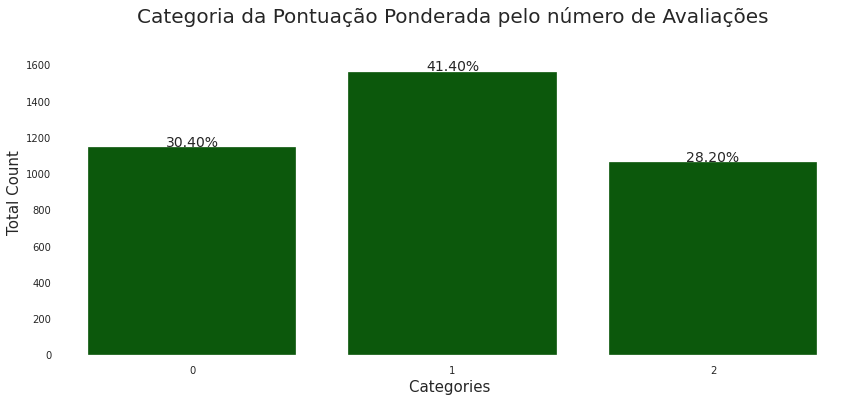

In [51]:
total = len(df)
plt.figure(figsize=(14,6))

g = sns.countplot(x='Pontuação_Cat', color='darkgreen',
                  data=df)
g.set_title("Categoria da Pontuação Ponderada pelo número de Avaliações", fontsize=20)
g.set_xlabel("Categories ", fontsize=15)
g.set_ylabel("Total Count", fontsize=15)

sizes=[]

for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format((height/total)*100),
            ha="center", fontsize=14) 
    
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

In [52]:
guarda = df.Potencial_Guarda.notna()
pd.qcut(df[guarda].Potencial_Guarda, 3)

Nome
Maison Le Star Rosé On Ice                                            (0.999, 4.0]
Ropiteau Frères Les Plants Nobles Pinot Noir 2017                     (0.999, 4.0]
Punta Paramo Malbec 2018                                               (6.0, 50.0]
Gérard Bertrand Grand Terroir A.O.P. Les Aspres 2015                   (6.0, 50.0]
Marqués de Somera Garnacha 2018                                       (0.999, 4.0]
                                                                          ...     
Viña Cosos D.O. Campo de Borja Garnacha Syrah 2018                      (4.0, 6.0]
Baron Philippe de Rothschild La Bélière A.O.C. Bordeaux Blanc 2017    (0.999, 4.0]
Carpineto Dogajolo I.G.T. Toscano Bianco 2017                         (0.999, 4.0]
Nederburg 56 Hundred Pinot Noir 2017                                  (0.999, 4.0]
Canepa Reserva Famiglia Carménère 2017                                  (4.0, 6.0]
Name: Potencial_Guarda, Length: 3727, dtype: category
Categories (3, interval[floa

In [53]:
def estoque_cat(points):
    if points < 5:
        return 1
    elif 5 <= points <= 10:
        return 2
    else:
        return 3    

In [54]:
df['Estoque_Cat'] = df.Potencial_Guarda.apply(estoque_cat)

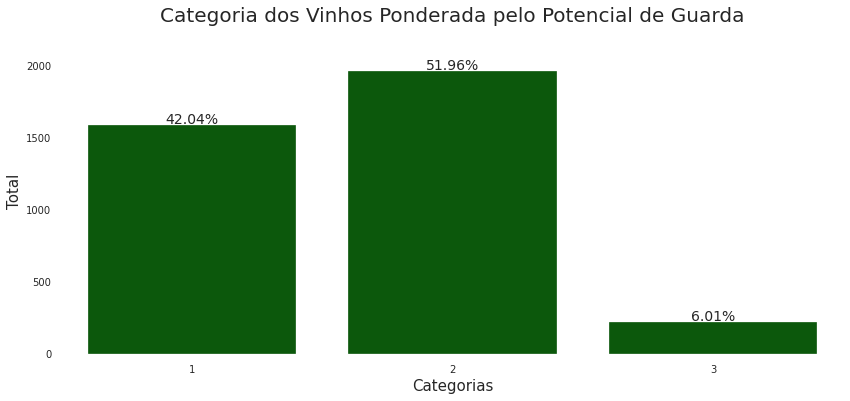

In [55]:
total = len(df)
plt.figure(figsize=(14,6))

g = sns.countplot(x='Estoque_Cat', color='darkgreen',
                  data=df)
g.set_title("Categoria dos Vinhos Ponderada pelo Potencial de Guarda", fontsize=20)
g.set_xlabel("Categorias", fontsize=15)
g.set_ylabel("Total", fontsize=15)

sizes=[]

for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format((height/total)*100),
            ha="center", fontsize=14) 
    
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

Vinhos 

In [56]:
df.head()

,Link,País,Preço_Sócio,Preço_Normal,Pontuação,Avaliações,Somelier,Decantação,Olfativo,Amadurecimento,...,Safra,Classificação,Teor_Alcoólico,Vinícola,Tipo,Potencial_Guarda,Região,Preços_Cat,Pontuação_Cat,Estoque_Cat
Nome,,,,,,,,,,,,,,,,,,,,,
Maison Le Star Rosé On Ice,https://wine.com.br/vinhos/maison-le-star-rose...,None,NaN,NaN,3.5,26.0,"Rosé francês frutado, leve, fresco e com doçur...",NaN,Frutas vermelhas,Em tanques de aço inox.,...,NaN,Meio Seco/Demi-Sec,11.5,Maison Le Star,Rosé,3.0,None,NaN,2,1
Ropiteau Frères Les Plants Nobles Pinot Noir 2017,https://wine.com.br/vinhos/ropiteau-freres-les...,França,NaN,NaN,4.5,44.0,"Com aroma de frutas vermelhas, sobre notas de ...",NaN,"Frutas vermelhas, tosta, baunilha, coco",Um terço do vinho estagiou em barricas de carv...,...,2017.0,Seco,12.5,Ropiteau Frères,Tinto,4.0,Languedoc,NaN,2,1
Punta Paramo Malbec 2018,https://wine.com.br/vinhos/punta-paramo-malbec...,Argentina,NaN,NaN,3.5,8.0,"Estilo de Malbec fácil de beber e macio, ideal...",NaN,"Frutas vermelhas, leve amadeirado, nuances de ...",Parte do vinho amadureceu em barricas de carva...,...,2018.0,Seco,13.8,Bodega Don Cristóbal 1492,Tinto,7.0,Mendoza,NaN,1,2
Gérard Bertrand Grand Terroir A.O.P. Les Aspres 2015,https://wine.com.br/vinhos/gerard-bertrand-gra...,França,NaN,NaN,1.0,2.0,Nasce de videiras cultivada em Les Aspres (ári...,30.0,"Frutas negras maduras, tosta, erva doce, noz-m...",33% do vinho por 9 meses em barris de carvalho.,...,2015.0,Seco,14.0,Gérard Bertrand,Tinto,7.0,Les Aspres,NaN,1,2
Marqués de Somera Garnacha 2018,https://wine.com.br/vinhos/marques-de-somera-g...,Espanha,NaN,NaN,4.0,17.0,Esse exemplar é elaborado na região espanhola ...,NaN,"Frutas vermelhas, pimenta-preta, violeta",Em tanques de aço inox.,...,2018.0,Seco,13.0,Covinca,Tinto,4.0,Cariñena,NaN,2,1


In [57]:
df.sort_values('Avaliações', ascending=False)

,Link,País,Preço_Sócio,Preço_Normal,Pontuação,Avaliações,Somelier,Decantação,Olfativo,Amadurecimento,...,Safra,Classificação,Teor_Alcoólico,Vinícola,Tipo,Potencial_Guarda,Região,Preços_Cat,Pontuação_Cat,Estoque_Cat
Nome,,,,,,,,,,,,,,,,,,,,,
Bear Flag Red Blend 2018,https://wine.com.br/vinhos/bear-flag-red-blend...,Estados Unidos,39.9,46.94,4.0,1014.0,O Bear Flag foi feito com o esforço em comum d...,NaN,"Frutas negras, com um leve tostado e um toque ...",Em tanques de aço inox,...,2018.0,Seco,13.50,Bear Flag,Tinto,5.0,Califórnia,1,2,2
Porta Soprana Lambrusco I.G.P. Emilia Rosso Amabile,https://wine.com.br/vinhos/porta-soprana-lambr...,Itália,NaN,NaN,4.5,424.0,Os frisantes da uva Lambrusco estão entre os v...,NaN,"Frutas vermelhas frescas, como cereja e morango",Não passa em barricas de carvalho.,...,NaN,Suave/Doce,7.50,Chiarli,Frisante,2.0,Emilia,NaN,2,1
Pedro Teixeira Colheita Selecionada Bairrada D.O.C 2018,https://wine.com.br/vinhos/pedro-teixeira-colh...,Portugal,34.9,41.06,4.0,389.0,"O renomado enólogo Osvaldo Amado fez, neste vi...",NaN,"Frutas vermelhas maduras, frutas em compota, e...",6 meses em barricas de carvalho francês mais m...,...,2018.0,Meio Seco/Demi-Sec,13.00,Adega de Cantanhede,Tinto,7.0,Bairrada,1,2,2
Espumante Veuve D`Argent Blanc De Blancs Brut,https://wine.com.br/vinhos/espumante-veuve-d-a...,França,36.9,43.41,4.0,360.0,"Frutas brancas como pera e maçã, delicadas not...",NaN,"Frutas brancas como pera e maçã, delicadas not...",3 meses em tanques de aço inox.,...,NaN,Brut,11.50,Veuve d'Argent,Espumante,2.0,Bourgogne,1,2,1
Vistamar Reserva V Carmenère 2018,https://wine.com.br/vinhos/vistamar-reserva-v-...,None,NaN,NaN,4.5,357.0,"Um exemplar de Carménère diferenciado, que tra...",NaN,"Frutas vermelhas, amora, ameixa, especiarias e...",em tanques de aço inox por 5 meses,...,2018.0,Meio Seco/Demi-Sec,13.00,Viña Vistamar,Tinto,5.0,None,NaN,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Julian Reynolds Branco 2013 375ml,https://wine.com.br/vinhos/julian-reynolds-bra...,Portugal,NaN,NaN,NaN,0.0,"Este vinho é rico em sabores e aromas, tem bom...",NaN,"Frutos tropicais como maracujá e abacaxi, com ...",Em tanques de aço inox,...,2013.0,NaN,14.00,Reynolds Wine Growers,Branco,4.0,Alentejo,NaN,0,1
Ventisquero Queulat Gran Reserva Syrah 2014,https://wine.com.br/vinhos/ventisquero-queulat...,None,NaN,NaN,NaN,0.0,Este é um syrah rico em aromas de frutas como ...,NaN,"Frutas como amoras, ameixas e mirtilos, sobre ...",12 meses em barricas de carvalho francês e ame...,...,2014.0,Seco,13.50,Viña Ventisquero,Tinto,7.0,None,NaN,0,2
William Hill Napa Valley Cabernet Sauvignon 2011,https://wine.com.br/vinhos/william-hill-napa-v...,Estados Unidos,NaN,NaN,NaN,0.0,"Aveludado, com taninos firmes, notas de frutas...",NaN,"Frutas vermelhas, amora, cereja e groselha, co...",19 meses em barricas de carvalho francês,...,2011.0,NaN,14.68,William Hill Estate Winery,Tinto,6.0,Napa Valley,NaN,0,2


In [58]:
df.Classificação.unique()

array(['Meio Seco/Demi-Sec', 'Seco', 'Brut', 'Suave/Doce', nan,
       'Extra Brut', 'Nature', 'Extra Dry'], dtype=object)

In [59]:
df.Classificação.value_counts()

Seco                  2560
Meio Seco/Demi-Sec     662
Brut                   189
Suave/Doce             117
Extra Brut              28
Nature                   9
Extra Dry                1
Name: Classificação, dtype: int64

In [60]:
df['Seco'] = 0

In [61]:
df.loc[(df.Classificação.notna()) & (df.Classificação == 'Seco'), 'Seco'] = 1

In [62]:
df.loc[(df.Classificação.notna()) & (df.Classificação == 'Extra Dry'), 'Seco'] = 1

In [63]:
df.Seco.value_counts()

1    2561
0    1219
Name: Seco, dtype: int64

In [64]:
df.Tipo.value_counts()

Tinto        2375
Branco        847
Espumante     300
Rosé          167
Licoroso       43
Frisante       21
Name: Tipo, dtype: int64

In [65]:
df.groupby('País')['Link'].count().sort_values(ascending=False).cumsum().apply(lambda x : x / total)

País
França            0.153704
Argentina         0.291270
Portugal          0.393386
Itália            0.492328
Espanha           0.585979
Brasil            0.669048
Estados Unidos    0.712963
África do Sul     0.753175
Uruguai           0.774603
Austrália         0.785979
Alemanha          0.792857
Hungria           0.797354
Name: Link, dtype: float64

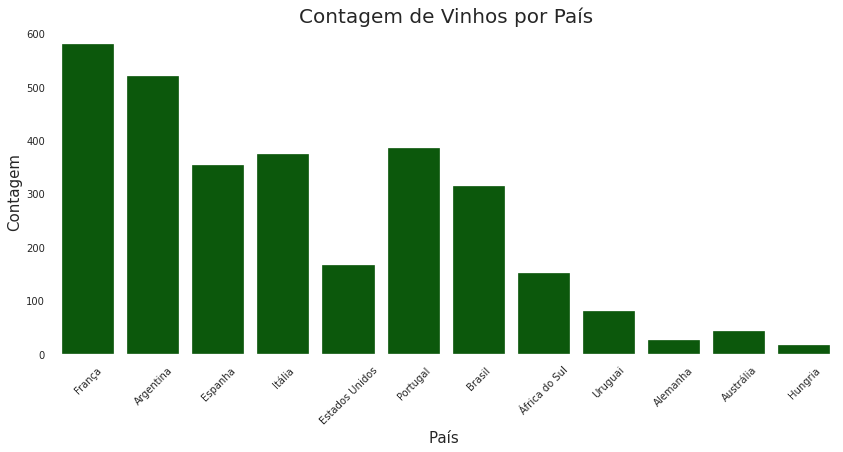

In [66]:
plt.figure(figsize=(14,6))

country = df.País.value_counts()

g = sns.countplot(x='País', 
                  data=df,
                 color='darkgreen')
g.set_title("Contagem de Vinhos por País", fontsize=20)
g.set_xlabel("País ", fontsize=15)
g.set_ylabel("Contagem", fontsize=15)
g.set_xticklabels(g.get_xticklabels(),rotation=45)

plt.show()

In [67]:
df['Pontuação'] = df.Pontuação.fillna(0)

In [68]:
df['Pontos_Total'] = df['Pontuação'] * df['Avaliações']

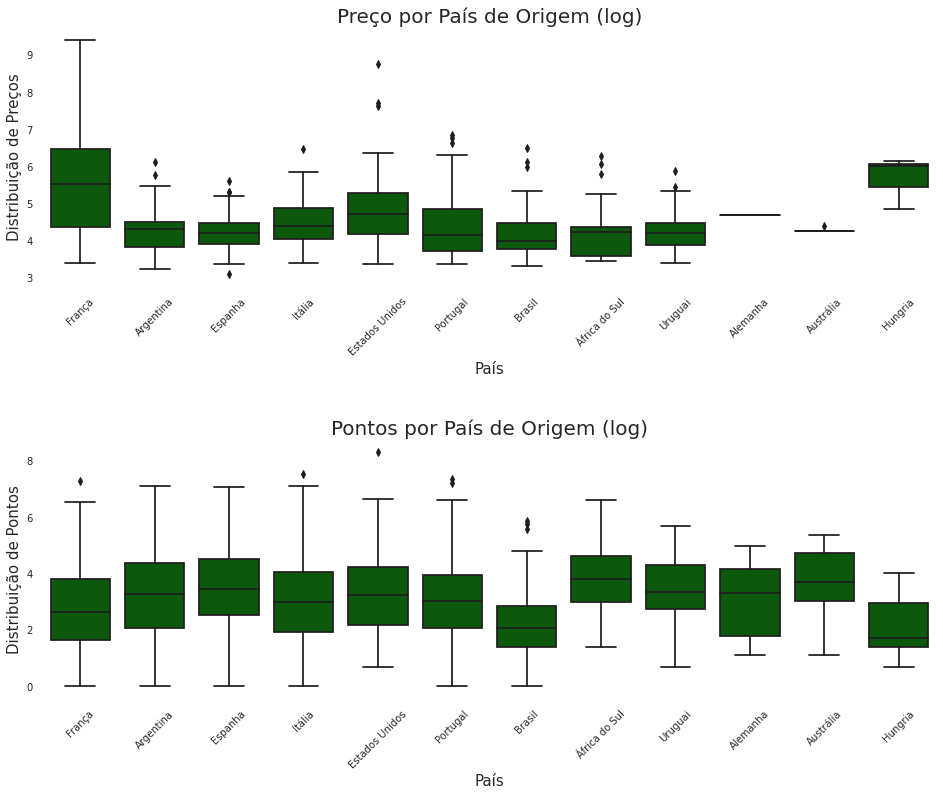

In [69]:
plt.figure(figsize=(16,12))

plt.subplot(2,1,1)

g = sns.boxplot(x='País', y=np.log(df.Preço_Normal.values), data=df, color='darkgreen')
g.set_title("Preço por País de Origem (log)", fontsize=20)
g.set_xlabel("País", fontsize=15)
g.set_ylabel("Distribuição de Preços", fontsize=15)
g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.subplot(2, 1, 2)

g = sns.boxplot(x='País', y=np.log(df[df.Pontos_Total != 0.0].Pontos_Total), data=df[df.Pontos_Total != 0.0], color='darkgreen')
g.set_title("Pontos por País de Origem (log)", fontsize=20)
g.set_xlabel("País", fontsize=15)
g.set_ylabel("Distribuição de Pontos", fontsize=15)
g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.subplots_adjust(hspace=0.6, top=0.9)

plt.show()



Interessante que o país de origem mais abundante, França, não possui vinhos com preço extremamente alto no nosso conjunto de dados, i.e. considerados outliers. 

In [70]:
df.groupby('País').Pontuação.median().sort_values(ascending=False)

País
África do Sul     4.00
Estados Unidos    4.00
Alemanha          3.75
Uruguai           3.50
Portugal          3.50
Itália            3.50
Espanha           3.50
França            3.00
Austrália         3.00
Argentina         3.00
Brasil            2.25
Hungria           0.00
Name: Pontuação, dtype: float64

In [71]:
df.groupby('País').Preço_Normal.median().sort_values(ascending=False)

País
Hungria           409.290
França            255.765
Estados Unidos    114.000
Alemanha          109.900
Itália             81.060
Argentina          76.350
Austrália          71.650
África do Sul      69.290
Uruguai            66.940
Espanha            66.940
Portugal           63.400
Brasil             54.000
Name: Preço_Normal, dtype: float64

In [72]:
for row in df.itertuples():
    df.loc[row.Index, 'Desc_Sócio'] = 1 - (row.Preço_Sócio / row.Preço_Normal) 

In [73]:
df.Desc_Sócio.mean()

0.14982712889273675

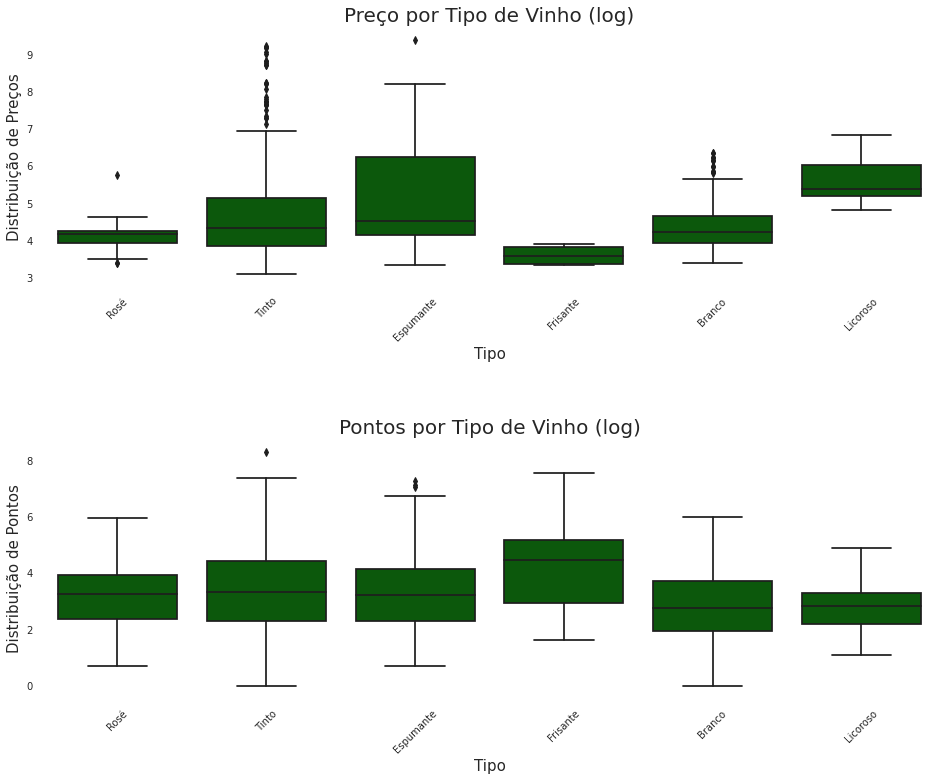

In [74]:
plt.figure(figsize=(16,12))

plt.subplot(2,1,1)

g = sns.boxplot(x='Tipo', y=np.log(df.Preço_Normal.values), data=df, color='darkgreen')
g.set_title("Preço por Tipo de Vinho (log)", fontsize=20)
g.set_xlabel("Tipo", fontsize=15)
g.set_ylabel("Distribuição de Preços", fontsize=15)
g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.subplot(2, 1, 2)

g = sns.boxplot(x='Tipo', y=np.log(df[df.Pontos_Total != 0.0].Pontos_Total), data=df[df.Pontos_Total != 0.0], color='darkgreen')
g.set_title("Pontos por Tipo de Vinho (log)", fontsize=20)
g.set_xlabel("Tipo", fontsize=15)
g.set_ylabel("Distribuição de Pontos", fontsize=15)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.subplots_adjust(hspace=0.6, top=0.9)
plt.show()


* Dado que a imensa maioria do catálogo é de vinhos tintos, não é surpresa que tenha o maior número de outliers. Mas os vinhos espumantes e licorosos possuem mediana de preços maior, ou seja, no geral são vinhos bem mais caros do catálogo.
* Os vinhos frisantes são os que possuem menor preço e maior pontuação na média, claro que possuem pouquíssimos vinhos disponíveis então não devemos levar essa estatística ao pé da letra.

In [75]:
df['Uvas'] = df.Uvas.str.split(",")

In [76]:
uvas = df.explode(column='Uvas')[['Uvas']]

In [77]:
uvas = uvas.reset_index()

In [78]:
import re
for row in uvas[uvas.Uvas.notna()].itertuples():
        m = re.match(r"([\w+ ]+)\s*\(?(\d*)\.?\d*%?\)?", row.Uvas.strip(), re.UNICODE)
        uvas.loc[row.Index, 'Uva'] = m.group(1).rstrip()
        conc = m.group(2).rstrip()
        uvas.loc[row.Index, 'Concentração'] = conc if conc != '' else 100 / len(uvas[uvas.Nome == row.Nome])

In [79]:
uvas = uvas.drop('Uvas', axis=1)

In [80]:
uvas

,Nome,Uva,Concentração
0,370 Léguas DOC Douro Branco 2017,Moscatel Galego Branco,33.3333
1,370 Léguas DOC Douro Branco 2017,Viosinho,33.3333
2,370 Léguas DOC Douro Branco 2017,Malvasia Fina,33.3333
3,370 Léguas Reserva D.O.C. Douro 2016,Tinta Roriz,35
4,370 Léguas Reserva D.O.C. Douro 2016,Touriga Franca,35
...,...,...,...
6694,Yellow Tail Shiraz 2016,Shiraz,100
6695,Zenithwirl Cabernet Gernischt 2018,Cabernet Gernisht,100
6696,Zenithwirl Cabernet Sauvignon 2018,Cabernet Sauvignon,100
6697,Zweigelt Classic Red 2017,Zweigelt,100


In [81]:
top_20 = uvas.Uva.value_counts()[:30]

top_20 = pd.DataFrame(top_20).reset_index()

top_20.columns = ['Uva', 'Count']

In [82]:
top_20

,Uva,Count
0,Cabernet Sauvignon,783
1,Merlot,517
2,Chardonnay,470
3,Syrah,429
4,Malbec,319
5,Pinot Noir,310
6,Sauvignon Blanc,211
7,Cabernet Franc,209
8,Tempranillo,163
9,Carménère,162


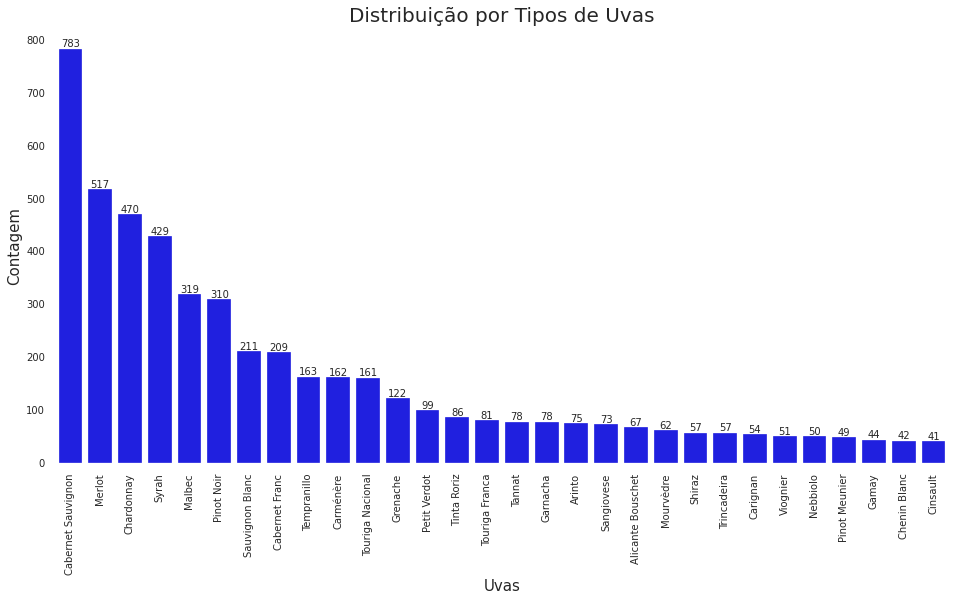

In [83]:
plt.figure(figsize=(16,8))


g = sns.barplot(x='Uva',
                y='Count',
                data=top_20,
                color='blue')
g.set_title("Distribuição por Tipos de Uvas", fontsize=20)
g.set_xlabel("Uvas", fontsize=15)
g.set_ylabel("Contagem", fontsize=15)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            int(height),
            ha="center", fontsize=10) 
    
plt.show()

In [84]:
uvas['Concentração'] = uvas.Concentração.astype(float)
uvas.Concentração.value_counts()

100.000000     2159
33.333333       948
50.000000       683
25.000000       421
20.000000       331
               ... 
31.000000         1
2530.000000       1
81.000000         1
78.000000         1
99.000000         1
Name: Concentração, Length: 104, dtype: int64

In [85]:
df['Puro'] = 0

In [86]:
for row in uvas[uvas.Concentração == 100].itertuples():
    df.loc[row.Nome, 'Puro'] = 1Esse vídeo mostra, ilustrando com tinta,  o modo correto de lavar as mãos.

In [87]:
df.index

Index(['Maison Le Star Rosé On Ice',
       'Ropiteau Frères Les Plants Nobles Pinot Noir 2017',
       'Punta Paramo Malbec 2018',
       'Gérard Bertrand Grand Terroir A.O.P. Les Aspres 2015',
       'Marqués de Somera Garnacha 2018',
       'Corello I.G.T. Puglia Primitivo 2018', 'Champagne Montaudon Brut',
       'Frisante Porta Soprana Lambrusco I.G.P. Emilia Branco Amabile Suave',
       'Dark Horse The Original California Rosé 2018',
       'Ropiteau Pinot Noir 2017',
       ...
       'Alfacinha RL Branco 2018',
       'Baron Philippe de Rothschild Cadet d'Oc Cabernet Sauvignon 2015',
       'Fantinel Tenuta SantHelena Pinot Grigio 2016',
       'Canepa Reserva Famiglia Syrah 2016',
       'Cuatro Elementos Canelones Tannat Merlot Suave 2018',
       'Viña Cosos D.O. Campo de Borja Garnacha Syrah 2018',
       'Baron Philippe de Rothschild La Bélière A.O.C. Bordeaux Blanc 2017',
       'Carpineto Dogajolo I.G.T. Toscano Bianco 2017',
       'Nederburg 56 Hundred Pinot Noir 2017

In [88]:
df.to_csv('all_wines_cleaned.csv')

In [89]:
df = pd.read_csv('all_wines_cleaned.csv')

In [90]:
df.columns

Index(['Nome', 'Link', 'País', 'Preço_Sócio', 'Preço_Normal', 'Pontuação',
       'Avaliações', 'Somelier', 'Decantação', 'Olfativo', 'Amadurecimento',
       'Uvas', 'Gustativo', 'Visual', 'Harmonização', 'Temperatura', 'Safra',
       'Classificação', 'Teor_Alcoólico', 'Vinícola', 'Tipo',
       'Potencial_Guarda', 'Região', 'Preços_Cat', 'Pontuação_Cat',
       'Estoque_Cat', 'Seco', 'Pontos_Total', 'Desc_Sócio', 'Puro'],
      dtype='object')